In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, R2Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

from Funcoes_Comuns import avaliar_modelo, registrar_modelo

In [2]:
# Definir a semente para reprodutibilidade
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### 1. Recuperar base já pré-processada

In [3]:
# Obter dados
df_enem = pd.read_pickle('Bases\\Finais\\enem_microdados_2023.pkl')

In [4]:
df_enem.head()

,NUM_NOTA_CH,NUM_NOTA_CN,NUM_NOTA_LC,NUM_NOTA_MT,NUM_NOTA_REDACAO,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,...,NUM_Q011,NUM_Q012,NUM_Q013,NUM_Q014,NUM_Q015,NUM_Q016,NUM_Q017,NUM_Q019,NUM_Q022,NUM_Q024
0,508.5,459.0,507.2,466.7,880.0,False,False,False,False,False,...,0,1,0,0,0,0,0,1,3,0
1,379.2,402.5,446.9,338.3,560.0,False,False,False,False,False,...,0,1,0,0,0,0,0,1,1,0
2,667.6,608.2,607.9,691.9,780.0,False,False,False,False,False,...,0,1,0,1,0,0,0,1,1,1
3,553.1,515.7,544.4,437.0,880.0,False,False,False,False,False,...,0,1,0,0,0,0,0,1,3,0
4,576.3,523.8,596.5,628.1,600.0,False,False,False,False,False,...,0,1,0,1,0,0,0,1,1,0


### 2. Pré-Processamento

One-hot Encoding

In [5]:
# Remover CAT_CO_MUNICIPIO_ESC devido alta cardinalidade
df_enem = df_enem.drop(columns=['CAT_CO_MUNICIPIO_ESC'])

In [6]:
# Aplicar o OneHotEncoder para converter as colunas categóricas em variáveis dummy
categorical_columns = df_enem.select_dtypes(include=['category']).columns
df_enem = pd.get_dummies(df_enem, columns=categorical_columns, drop_first=True)

In [7]:
df_enem.head()

,NUM_NOTA_CH,NUM_NOTA_CN,NUM_NOTA_LC,NUM_NOTA_MT,NUM_NOTA_REDACAO,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,...,CAT_Q003_F,CAT_Q004_B,CAT_Q004_C,CAT_Q004_D,CAT_Q004_E,CAT_Q004_F,CAT_SEXO_M,CAT_SIT_FUNC_ESC_2,CAT_SIT_FUNC_ESC_3,CAT_SIT_FUNC_ESC_4
0,508.5,459.0,507.2,466.7,880.0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,379.2,402.5,446.9,338.3,560.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,667.6,608.2,607.9,691.9,780.0,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
3,553.1,515.7,544.4,437.0,880.0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,576.3,523.8,596.5,628.1,600.0,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False


In [ ]:
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']
grupo_previsao = ['NUM_NOTA_CH']

# separar em treino e teste
X = df_enem.drop(columns=variaveis_alvo)
y = df_enem[grupo_previsao]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Criar Eval Set para validação cruzada (15% do conjunto de treino)
X_train_final, X_eval, y_train_final, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=seed
)

Normalização -> Testar StandardScaler (melhor) e MinMaxScaler

In [9]:
# Identificar colunas booleanas e outras
bool_cols_X = X_train_final.select_dtypes(include=['bool']).columns
num_cols_X = X_train_final.select_dtypes(include=[np.number]).columns.difference(bool_cols_X)

In [10]:
X_train_final

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,NUM_Q001,NUM_Q002,NUM_Q005,...,CAT_Q003_F,CAT_Q004_B,CAT_Q004_C,CAT_Q004_D,CAT_Q004_E,CAT_Q004_F,CAT_SEXO_M,CAT_SIT_FUNC_ESC_2,CAT_SIT_FUNC_ESC_3,CAT_SIT_FUNC_ESC_4
19224,False,False,False,False,False,False,True,2,2,5,...,False,False,False,False,False,True,True,False,False,False
671114,False,False,True,True,False,False,True,5,1,4,...,False,True,False,False,False,False,False,False,False,False
685019,False,False,True,False,True,False,True,4,4,3,...,False,False,True,False,False,False,True,False,False,False
700122,False,False,False,False,False,False,True,2,4,3,...,False,True,False,False,False,False,True,False,False,False
493666,False,False,False,False,False,False,True,4,4,4,...,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693167,False,False,False,False,False,False,True,2,2,5,...,False,False,False,True,False,False,True,False,False,False
26031,False,False,True,False,False,False,True,4,2,5,...,False,True,False,False,False,False,True,False,False,False
209654,False,False,False,False,False,False,True,5,4,5,...,False,True,False,False,False,False,False,False,False,False
57280,False,False,False,False,False,False,True,3,3,4,...,False,False,False,False,False,True,False,False,False,False


In [11]:
# Normalizar X - Referencia apenas cunjunto de treino
X_scaler_base = StandardScaler()
X_train_final[num_cols_X] = X_scaler_base.fit_transform(X_train_final[num_cols_X])
X_eval[num_cols_X] = X_scaler_base.transform(X_eval[num_cols_X])
X_test[num_cols_X] = X_scaler_base.transform(X_test[num_cols_X])

# Normalizar y - Referencia apenas cunjunto de treino (não há colunas booleanas)
y_scaler_base = StandardScaler()
y_train_final = y_scaler_base.fit_transform(y_train_final)
y_eval = y_scaler_base.transform(y_eval)
y_test = y_scaler_base.transform(y_test)

In [12]:
# Converter dados para modelo - redes neurais esperam dados em numpy arrays
X_train_final = X_train_final.astype(np.float32)
X_eval = X_eval.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train_final = y_train_final.astype(np.float32)
y_eval = y_eval.astype(np.float32)
y_test = y_test.astype(np.float32)

### 3. Modelo base 
(sem variável CAT_CO_MUNICIPIO_ESC devido alta dimensionalidade do One-Hot)

In [13]:
# Construir a rede neural com 5 camadas
model = Sequential([
    Input(shape=(X_train_final.shape[1],)),                # Camada de entrada
    Dense(64, activation='relu'),                          # Camada oculta 1
    Dense(32, activation='relu'),                          # Camada oculta 2
    Dense(16, activation='relu'),                          # Camada oculta 3
    Dense(8, activation='relu'),                           # Camada oculta 4
    Dense(units=len(grupo_previsao), activation='linear')  # Camada de saída para regressão: 1 variável, ativação linear
])

In [14]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=5,                   # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='mse',                   # Função de perda
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [15]:
# Treinar o modelo

start_time = time.time()

history = model.fit(
    X_train_final, 
    y_train_final,
    validation_data=(X_eval, y_eval),    # Usar o conjunto validação
    epochs=50,                           # Número máximo de épocas
    batch_size=256,                      # Tamanho do batch
    callbacks=[early_stopping],          # Usar early stopping
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.7307 - mean_absolute_error: 0.6747 - r2_score: 0.2669 - root_mean_squared_error: 0.8545 - val_loss: 0.6985 - val_mean_absolute_error: 0.6586 - val_r2_score: 0.3044 - val_root_mean_squared_error: 0.8357
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.7307 - mean_absolute_error: 0.6747 - r2_score: 0.2669 - root_mean_squared_error: 0.8545 - val_loss: 0.6985 - val_mean_absolute_error: 0.6586 - val_r2_score: 0.3044 - val_root_mean_squared_error: 0.8357
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6909 - mean_absolute_error: 0.6560 - r2_score: 0.3069 - root_mean_squared_error: 0.8312 - val_loss: 0.6955 - val_mean_absolute_error: 0.6567 - val_r2_score: 0.3074 - val_root_mean_squared_error: 0.8340
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6909 - mean_absolute_error: 0.6560 - r2_score: 0.3069 - root_mean_squared_error: 0.8312 - val_loss: 0.6955 - val_mean_absolute_error: 0.

In [16]:
# Avaliar o modelo no conjunto de teste
model.evaluate(X_test, y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6902 - mean_absolute_error: 0.6547 - r2_score: 0.3090 - root_mean_squared_error: 0.8308
4479/4479 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6902 - mean_absolute_error: 0.6547 - r2_score: 0.3090 - root_mean_squared_error: 0.8308


[0.6881849765777588,
 0.6535601019859314,
 0.8295691609382629,
 0.3085781931877136]

    Com uso de one-hot
    Impossível com o hardware atual

    Com uso de one-hot encoder sem Código do Municipio (Possui mais de 5000 categorias)
    [50.6934848427772522, 0.6552520394325256, 0.8327573537826538, 0.304974317550659]

In [17]:
# Previsões
y_pred_base = model.predict(X_test)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4479/4479 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [18]:
# Desnormalizar
y_test_desnorm = y_scaler_base.inverse_transform(y_test)
y_pred_desnorm = y_scaler_base.inverse_transform(y_pred_base)
y_train_desnorm = y_scaler_base.inverse_transform(y_train_final)

In [19]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 256,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train_final),
                        'embedding_dim': 0,  # Não foi utilizado embedding
                        'patience': early_stopping.patience,
                        'optimizer': 'adam',
                        'learning_rate': model.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.0,  # Não foi utilizado dropout
                        'batch_normalization': False,
                    },
                 X_train=X_train_final,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model,
                 nome_modelo='modelo_RNA_base_sem_municipio',
                 descricao_modelo='Modelo de RNA base sem utilização do código do município'
                )

Registered model 'modelo_RNA_base_sem_municipio' already exists. Creating a new version of this model...
2025/08/09 17:06:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_base_sem_municipio, version 5


🏃 View run amazing-mule-138 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/a8e7719814e441b591303c3701a84357
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_base_sem_municipio
Rastreamento do MLflow finalizado.


Created version '5' of model 'modelo_RNA_base_sem_municipio'.


In [25]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler_base.inverse_transform(model.predict(X_train_final)), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15226/15226 ━━━━━━━━━━━━━━━━━━━━ 14s 923us/step
MAE (treino): 55.0201
RMSE (treino): 69.9149
R2 (treino): 0.3175
MAE (teste): 55.3117
RMSE (teste): 70.2076
R2 (teste): 0.3086


In [26]:
# Salvar o modelo otimizado como um arquivo
model.save('Modelos\\modelo_RNA_base.keras')

### 4. Modelo com Embedding
Testar Embedding para coluna CO_MUNICIPIO_ESC

In [27]:
# Obter dados
df_enem = pd.read_pickle('Bases\\Finais\\enem_microdados_2023.pkl')

In [28]:
# 1. Separar a coluna de alta cardinalidade
municipio_col = 'CAT_CO_MUNICIPIO_ESC'
municipios = df_enem[municipio_col].astype(str)  # garantir string para LabelEncoder
X_features = df_enem.drop(columns=[municipio_col] + variaveis_alvo)

In [29]:
# 2. Codificar a coluna como inteiros
le_municipio = LabelEncoder()
municipios_encoded = le_municipio.fit_transform(municipios)

In [30]:
# 3. One-hot para as demais features
categorical_columns = X_features.select_dtypes(include=['category']).columns
X_features = pd.get_dummies(X_features, columns=categorical_columns, drop_first=True)

    f: features
    m: municipios

In [31]:
# 4. Separar treino/teste/validação para ambos
X_train_f, X_test_f, X_train_m, X_test_m, y_train, y_test = train_test_split(
    X_features, municipios_encoded, df_enem[grupo_previsao], test_size=0.2, random_state=seed
)
X_train_f, X_eval_f, X_train_m, X_eval_m, y_train, y_eval = train_test_split(
    X_train_f, X_train_m, y_train, test_size=0.15, random_state=seed
)

In [32]:
# 5. Normalizar demais features e y
# Normalizar X - Referencia apenas cunjunto de treino
X_scaler_emb = StandardScaler()
X_train_f = X_scaler_emb.fit_transform(X_train_f)
X_eval_f = X_scaler_emb.transform(X_eval_f)
X_test_f = X_scaler_emb.transform(X_test_f)

# Normalizar y - Referencia apenas cunjunto de treino (não há colunas booleanas)
y_scaler_emb = StandardScaler()
y_train = y_scaler_emb.fit_transform(y_train)
y_eval = y_scaler_emb.transform(y_eval)
y_test = y_scaler_emb.transform(y_test)

In [33]:
# 6. Converter dados para modelo - redes neurais esperam dados em numpy arrays
X_train_f = X_train_f.astype(np.float32)
X_eval_f = X_eval_f.astype(np.float32)
X_test_f = X_test_f.astype(np.float32)

y_train = y_train.astype(np.float32)
y_eval = y_eval.astype(np.float32)
y_test = y_test.astype(np.float32)

In [34]:
# 7. Modelo funcional com embedding

# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

In [35]:
# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

In [36]:
# Concatenar
x = Concatenate()([input_features, x_municipio])

In [37]:
# Camadas densas
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_embedding = Model(inputs=[input_features, input_municipio], outputs=output)

In [38]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=5,                   # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar
model_embedding.compile(
    optimizer='adam',
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [39]:
start_time = time.time()

# Treinar o modelo com embedding
history = model_embedding.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7319 - mean_absolute_error: 0.6770 - r2_score: 0.2657 - root_mean_squared_error: 0.8552 - val_loss: 0.6921 - val_mean_absolute_error: 0.6552 - val_r2_score: 0.3108 - val_root_mean_squared_error: 0.8319
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6823 - mean_absolute_error: 0.6514 - r2_score: 0.3155 - root_mean_squared_error: 0.8260 - val_loss: 0.6891 - val_mean_absolute_error: 0.6535 - val_r2_score: 0.3138 - val_root_mean_squared_error: 0.8301
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6751 - mean_absolute_error: 0.6477 - r2_score: 0.3228 - root_mean_squared_error: 0.8216 - val_loss: 0.6891 - val_mean_absolute_error: 0.6534 - val_r2_score: 0.3138 - val_root_mean_squared_error: 0.8301
Epoch 4/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6705 - mean_absolute_error: 0.6453 - r2_score: 0.3273 - root_mean_squared_error: 0.8188 - val_loss: 0.6905 - val_mean_absolute_error: 0.6

In [40]:
# Avaliar o modelo no conjunto de teste
model_embedding.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.6868 - mean_absolute_error: 0.6526 - r2_score: 0.3124 - root_mean_squared_error: 0.8287


[0.6846786141395569, 0.6513265371322632, 0.827453076839447, 0.3121010661125183]

In [41]:
# Previsões
y_pred_emb = model_embedding.predict([X_test_f, X_test_m])

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [42]:
# Desnormalizar
y_test_desnorm = y_scaler_emb.inverse_transform(y_test)
y_pred_desnorm = y_scaler_emb.inverse_transform(y_pred_emb)
y_train_desnorm = y_scaler_emb.inverse_transform(y_train)

In [43]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 256,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train_f),
                        'embedding_dim': embedding_dim,
                        'patience': early_stopping.patience,
                        'optimizer': 'adam',
                        'learning_rate': model_embedding.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.0,  # Não foi utilizado dropout
                        'batch_normalization': False,
                    },
                 X_train=X_train_f,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model_embedding,
                 nome_modelo='modelo_RNA_embedding_municipio',
                 descricao_modelo='Modelo de RNA com embedding para o código do município'
                )

Registered model 'modelo_RNA_embedding_municipio' already exists. Creating a new version of this model...
2025/08/09 17:12:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_embedding_municipio, version 4


🏃 View run resilient-cat-585 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/7dd79096e06b4675b38fd90428483ffe
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_embedding_municipio
Rastreamento do MLflow finalizado.


Created version '4' of model 'modelo_RNA_embedding_municipio'.


In [44]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler_emb.inverse_transform(model_embedding.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15226/15226 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
MAE (treino): 54.6056
RMSE (treino): 69.4350
R2 (treino): 0.3269
MAE (teste): 55.1226
RMSE (teste): 70.0285
R2 (teste): 0.3121


In [45]:
# Salvar o modelo otimizado como um arquivo
model_embedding.save('Modelos\\modelo_RNA_base_embedding.keras')

    Modelo com Embedding se saiu melhor

    Indica que o município da escola importa
    
    Bom sinal para inclusão dos dados do censo que detalham mais as características da escola de cada município

### 5. Modelo otimizado em alguns parâmetros
Deixar modelo mais elaborado: parametros melhores, camadas

    Utilizar otimizador Nadam
    Mudar learning rate
    Aumementar camadas
    Reduzir Batch size
    Aumentar patience (early stopping)

In [47]:
# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

# Concatenar
x = Concatenate()([input_features, x_municipio])

In [48]:
# Camadas densas
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_emb_param = Model(inputs=[input_features, input_municipio], outputs=output)

In [49]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=10,                  # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar e treinar
model_emb_param.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [50]:
start_time = time.time()

# Treinar o modelo com embedding e parâmetros ajustados
history = model_emb_param.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.7174 - mean_absolute_error: 0.6692 - r2_score: 0.2802 - root_mean_squared_error: 0.8468 - val_loss: 0.6892 - val_mean_absolute_error: 0.6556 - val_r2_score: 0.3137 - val_root_mean_squared_error: 0.8302
Epoch 2/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.6808 - mean_absolute_error: 0.6507 - r2_score: 0.3170 - root_mean_squared_error: 0.8251 - val_loss: 0.6874 - val_mean_absolute_error: 0.6541 - val_r2_score: 0.3155 - val_root_mean_squared_error: 0.8291
Epoch 3/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.6736 - mean_absolute_error: 0.6468 - r2_score: 0.3242 - root_mean_squared_error: 0.8207 - val_loss: 0.6877 - val_mean_absolute_error: 0.6539 - val_r2_score: 0.3152 - val_root_mean_squared_error: 0.8293
Epoch 4/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.6683 - mean_absolute_error: 0.6439 - r2_score: 0.3296 - root_mean_squared_error: 0.8175 - val_loss: 0.6899 - val_mean_absolute_error: 

In [51]:
# Avaliar o modelo no conjunto de teste
model_emb_param.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.6846 - mean_absolute_error: 0.6530 - r2_score: 0.3146 - root_mean_squared_error: 0.8274


[0.6828531622886658,
 0.6518163681030273,
 0.8263493180274963,
 0.3139351010322571]

In [52]:
# Previsões
y_pred_opt = model_emb_param.predict([X_test_f, X_test_m])

# Desnormalizar
y_test_desnorm = y_scaler_emb.inverse_transform(y_test)
y_pred_desnorm = y_scaler_emb.inverse_transform(y_pred_opt)
y_train_desnorm = y_scaler_emb.inverse_transform(y_train)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [53]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 128,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train_f),
                        'embedding_dim': embedding_dim,
                        'patience': early_stopping.patience,
                        'optimizer': 'Nadam',
                        'learning_rate':model_emb_param.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.0,  # Não foi utilizado dropout
                        'batch_normalization': False,
                    },
                 X_train=X_train_f,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model_emb_param,
                 nome_modelo='modelo_RNA_embedding_municipio_melhores_parametros',
                 descricao_modelo='Modelo de RNA com embedding para o código do município com melhores parâmetros de treinamento'
                )

Registered model 'modelo_RNA_embedding_municipio_melhores_parametros' already exists. Creating a new version of this model...
2025/08/09 17:17:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_embedding_municipio_melhores_parametros, version 3


🏃 View run welcoming-smelt-719 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/59f8a3aef4634115b823c1071de2f0a4
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_embedding_municipio_melhores_parametros
Rastreamento do MLflow finalizado.


Created version '3' of model 'modelo_RNA_embedding_municipio_melhores_parametros'.


In [54]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler_emb.inverse_transform(model_emb_param.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15226/15226 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
MAE (treino): 54.6067
RMSE (treino): 69.3144
R2 (treino): 0.3292
MAE (teste): 55.1641
RMSE (teste): 69.9351
R2 (teste): 0.3139


### 6. Modelo com Dropout + Batch Normalization
Aplicar Dropout e Batch Normalization no modelo base

In [55]:
# Modelo com Embedding, Dropout e BatchNormalization

# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

# Concatenar
x = Concatenate()([input_features, x_municipio])

In [56]:
# Camadas densas
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_emb_drop_bat = Model(inputs=[input_features, input_municipio], outputs=output)

In [57]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=10,                  # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar e treinar
model_emb_drop_bat.compile(
    optimizer=Nadam(learning_rate=0.0005),
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [58]:
start_time = time.time()

# Treinar modelo com embedding, dropout e batch normalization
history = model_emb_drop_bat.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.9058 - mean_absolute_error: 0.7474 - r2_score: 0.0910 - root_mean_squared_error: 0.9494 - val_loss: 0.7176 - val_mean_absolute_error: 0.6693 - val_r2_score: 0.2854 - val_root_mean_squared_error: 0.8471
Epoch 2/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.7227 - mean_absolute_error: 0.6727 - r2_score: 0.2751 - root_mean_squared_error: 0.8501 - val_loss: 0.6986 - val_mean_absolute_error: 0.6598 - val_r2_score: 0.3043 - val_root_mean_squared_error: 0.8358
Epoch 3/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.7019 - mean_absolute_error: 0.6624 - r2_score: 0.2959 - root_mean_squared_error: 0.8378 - val_loss: 0.6920 - val_mean_absolute_error: 0.6563 - val_r2_score: 0.3109 - val_root_mean_squared_error: 0.8319
Epoch 4/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.6930 - mean_absolute_error: 0.6575 - r2_score: 0.3049 - root_mean_squared_error: 0.8324 - val_loss: 0.6903 - val_mean_absolute_error: 0.6555 - v

In [59]:
# Avaliar o modelo no conjunto de teste
model_emb_drop_bat.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.6851 - mean_absolute_error: 0.6530 - r2_score: 0.3142 - root_mean_squared_error: 0.8277


[0.6834394931793213,
 0.6519195437431335,
 0.8267039656639099,
 0.3133459687232971]

In [60]:
# Previsões
y_pred_drop = model_emb_drop_bat.predict([X_test_f, X_test_m])

# Desnormalizar
y_test_desnorm = y_scaler_emb.inverse_transform(y_test)
y_pred_desnorm = y_scaler_emb.inverse_transform(y_pred_drop)
y_train_desnorm = y_scaler_emb.inverse_transform(y_train)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [61]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 512,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train_f),
                        'embedding_dim': embedding_dim,
                        'patience': early_stopping.patience,
                        'optimizer': 'Nadam',
                        'learning_rate': model_emb_drop_bat.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.3,
                        'batch_normalization': True
                    },
                 X_train=X_train_f,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model_emb_drop_bat,
                 nome_modelo='modelo_RNA_embedding_municipio_drop_bat',
                 descricao_modelo='Modelo de RNA com embedding, dropout e batch normalization para o código do município'
                )

Registered model 'modelo_RNA_embedding_municipio_drop_bat' already exists. Creating a new version of this model...
2025/08/09 17:31:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_embedding_municipio_drop_bat, version 2


🏃 View run omniscient-cod-497 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/4cab1ab4b5d64eb1a4653dcd69619b40
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_embedding_municipio_drop_bat
Rastreamento do MLflow finalizado.


Created version '2' of model 'modelo_RNA_embedding_municipio_drop_bat'.


In [62]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler_emb.inverse_transform(model_emb_drop_bat.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15226/15226 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
MAE (treino): 54.4727
RMSE (treino): 69.1351
R2 (treino): 0.3327
MAE (teste): 55.1729
RMSE (teste): 69.9652
R2 (teste): 0.3133


In [63]:
# Salvar o modelo otimizado como um arquivo
model_emb_drop_bat.save('Modelos\\modelo_RNA_base_embedding_dropout_batchnorm.keras')

### 7. Análise de resultados do modelo com Dropout + BatchNorm

In [64]:
import matplotlib.pyplot as plt

# Função para customizar o gráfico conforme solicitado
def custom_plot(x, y1, y2, label1, label2, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, y1, label=label1)
    ax.plot(x, y2, label=label2)
    
    # Remover título
    # ax.set_title('')  # Não definir título
    
    # Customizar eixos principais
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.5)
    
    # Remover linhas de grade
    ax.grid(False)
    
    # Remover preenchimento
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Títulos dos eixos
    ax.set_xlabel(xlabel, fontname='Arial', fontsize=14, color='black')
    ax.set_ylabel(ylabel, fontname='Arial', fontsize=14, color='black')
    
    # Legenda com fonte 14
    ax.legend(fontsize=14)
    plt.show()

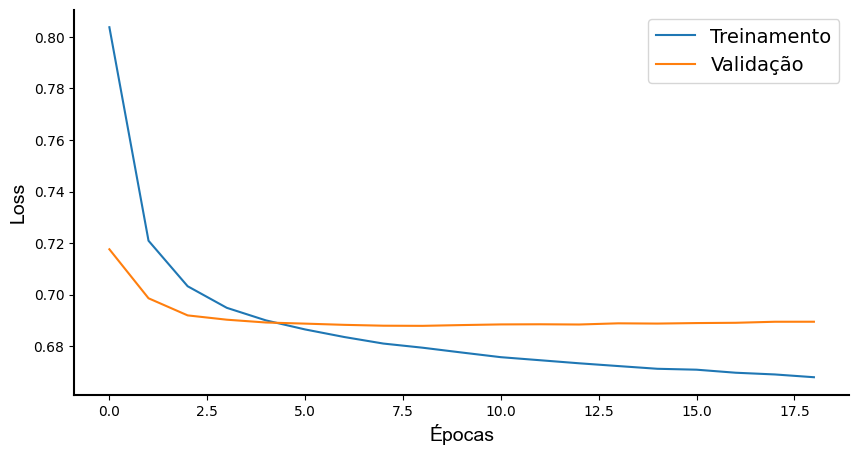

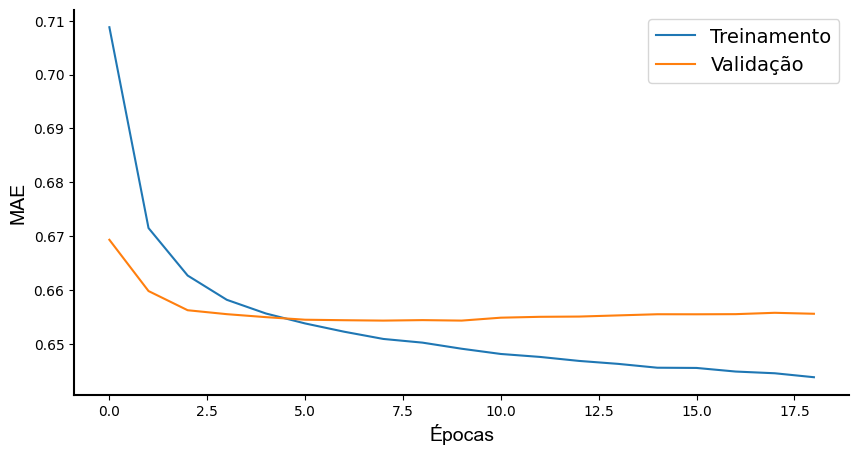

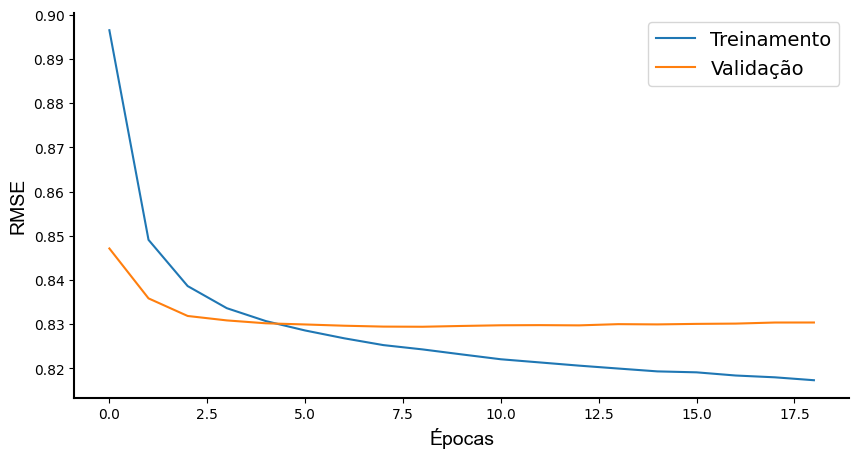

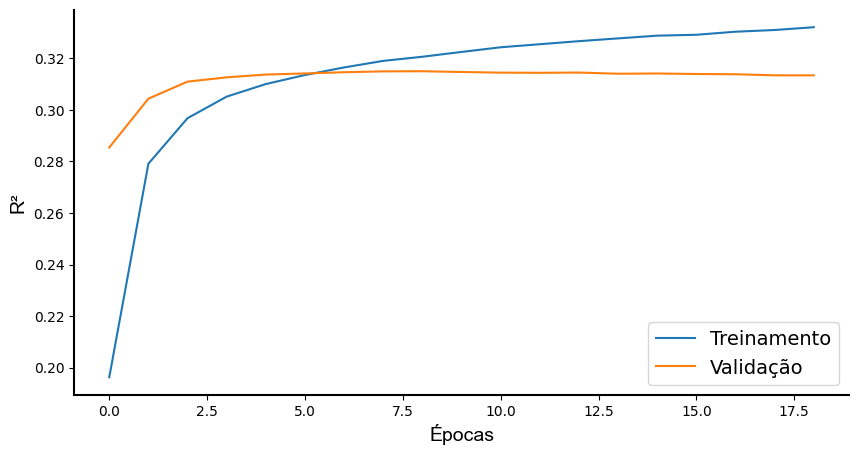

In [65]:
# Exemplo de uso da função custom_plot para os principais gráficos de treinamento

# Gráfico de perda (loss)
custom_plot(
    range(len(history.history['loss'])),
    history.history['loss'],
    history.history['val_loss'],
    'Treinamento',
    'Validação',
    'Épocas',
    'Loss'
)

# Gráfico de MAE
if 'mean_absolute_error' in history.history and 'val_mean_absolute_error' in history.history:
    custom_plot(
        range(len(history.history['mean_absolute_error'])),
        history.history['mean_absolute_error'],
        history.history['val_mean_absolute_error'],
        'Treinamento',
        'Validação',
        'Épocas',
        'MAE'
    )

# Gráfico de RMSE
if 'root_mean_squared_error' in history.history and 'val_root_mean_squared_error' in history.history:
    custom_plot(
        range(len(history.history['root_mean_squared_error'])),
        history.history['root_mean_squared_error'],
        history.history['val_root_mean_squared_error'],
        'Treinamento',
        'Validação',
        'Épocas',
        'RMSE'
    )

# Gráfico de R2 Score
if 'r2_score' in history.history and 'val_r2_score' in history.history:
    custom_plot(
        range(len(history.history['r2_score'])),
        history.history['r2_score'],
        history.history['val_r2_score'],
        'Treinamento',
        'Validação',
        'Épocas',
        'R²'
    )